#### Quiero hacer unos randoms que tengan el gradiente en DEC que tienen los rayos cosmicos

In [4]:
def generate_RandomCatalogue_with_CRgradient(N, nmult, dec_max, cr_ra, cr_dec,
                                             seed=None, milkyway_mask=True,
                                             deflection=None,
                                             deflection_file='../data/JF12_GMFdeflection_Z1_E10EeV.csv'):
    import numpy as np
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from scipy.stats import binned_statistic_2d

    if seed is not None:
        np.random.seed(seed)

    # Bin cosmic ray density on the sky
    nbins = 60  # resolution of density map (adjust if needed)
    H, xedges, yedges, _ = binned_statistic_2d(
        cr_ra, cr_dec, None, statistic='count',
        bins=[np.linspace(0, 360, nbins+1), np.linspace(-90, dec_max, nbins+1)]
    )
    H = H.T  # So rows = Dec, cols = RA

    # Normalize and flatten for probability sampling
    H = np.nan_to_num(H)
    H += 1e-6  # to avoid zero-probability regions
    H /= H.sum()  # normalize to make it a probability map

    # Generate large pool of randoms
    ra_pool = np.random.uniform(0, 360, N * nmult * 100)
    sin_dec_pool = np.random.uniform(np.sin(np.radians(-90)), np.sin(np.radians(dec_max)), N * nmult * 100)
    dec_pool = np.degrees(np.arcsin(sin_dec_pool))

    # Apply Milky Way mask
    if milkyway_mask:
        coords = SkyCoord(ra_pool, dec_pool, frame='icrs', unit='degree')
        mask = np.abs(coords.galactic.b.deg) > 5.
        ra_pool, dec_pool = ra_pool[mask], dec_pool[mask]

    # Apply deflection mask
    if deflection in ['low', 'high']:
        randoms = np.column_stack((ra_pool, dec_pool))
        deflection_mask = apply_deflection_mask(deflection_file, randoms[:, 0], randoms[:, 1], deflection)
        randoms = randoms[deflection_mask]
        ra_pool, dec_pool = randoms[:, 0], randoms[:, 1]

    # Rejection sampling based on CR density
    ra_idx = np.searchsorted(xedges, ra_pool, side='right') - 1
    dec_idx = np.searchsorted(yedges, dec_pool, side='right') - 1

    valid = (ra_idx >= 0) & (ra_idx < nbins) & (dec_idx >= 0) & (dec_idx < nbins)
    ra_pool, dec_pool, ra_idx, dec_idx = ra_pool[valid], dec_pool[valid], ra_idx[valid], dec_idx[valid]

    probs = H[dec_idx, ra_idx]
    probs /= probs.max()  # normalize to [0, 1] for rejection sampling

    accept = np.random.uniform(0, 1, size=probs.size) < probs
    ra_selected = ra_pool[accept]
    dec_selected = dec_pool[accept]

    # Final cut to desired size
    if ra_selected.size < N * nmult:
        raise RuntimeError("Not enough randoms passed the rejection sampling. Increase pool size or relax mask.")
    
    return ra_selected[:N*nmult], dec_selected[:N*nmult]




In [5]:
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u

events_a8 = ascii.read('../data/Auger/events_a8_lb.dat')
eve = SkyCoord(events_a8['RA'], events_a8['dec'], frame='icrs', unit='degree')
mask_eve = np.where(abs(eve.galactic.b) > 5. * u.degree)[0]
events_a8 = events_a8[mask_eve]
#mask_eve = np.where(events_a8['dec']< 0.)[0]
#events_a8 = events_a8[mask_eve]

cr_ra = events_a8['RA']
cr_dec = events_a8['dec']

randoms = generate_RandomCatalogue_with_CRgradient(N=len(cr_ra), nmult=10, cr_ra=cr_ra, cr_dec=cr_dec, dec_max=45)

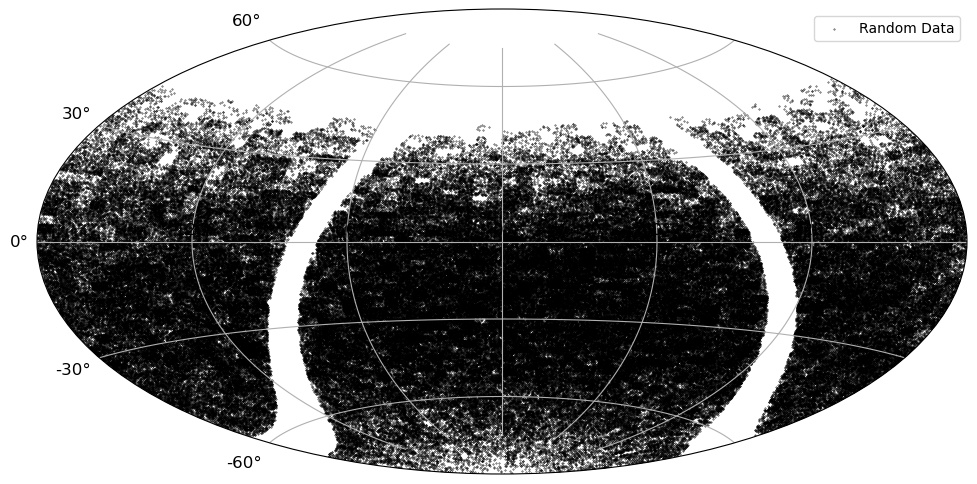

In [7]:
def format_axes(ax):
    """Format axes with RA in hours and Dec in degrees."""
    xticks_deg = [-120, -60, 0, 60, 120]
    xticks_rad = np.radians(xticks_deg)
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f'{int(deg)}°' for deg in xticks_deg])
    yticks_deg = [-60, -30, 0, 30, 60]
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f'{deg}°' for deg in yticks_deg])
    ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid(True)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': 'aitoff'})        

# Ensure axs is always iterable
#axs = np.array(axs).reshape(-1)

#for q, ax in zip(range(params['nquant']),axs):
#    gxs_sc = SkyCoord(data[q]['_RAJ2000'],data[q]['_DEJ2000'],frame='icrs',unit='degree')

#    eve_sc = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
ran_sc = SkyCoord(randoms[0], randoms[1],frame='icrs',unit='degree')

ax.scatter(ran_sc.ra.wrap_at(180*u.degree).to(u.rad),ran_sc.dec.to(u.rad),s=.1,c='k',label='Random Data')
#ax.scatter(eve_sc.ra.wrap_at(180*u.degree).to(u.rad),eve_sc.dec.to(u.rad),s=.1,label='UHECRs')
#ax.scatter(gxs_sc.ra.wrap_at(180*u.degree).to(u.rad),gxs_sc.dec.to(u.rad),s=5,c='C03',label='Galaxies')

ax.legend(loc=1,fontsize=10)
#ax.set_title(f'{quantiles[q]:.1f} '+r'< K_{abs} < '+f'{quantiles[q+1]:.1f}')
ax.grid(True)
format_axes(ax)

plt.show()

#### Empiezo de nuevo

(array([ 107.,  346.,  553.,  782., 1023.,  937.,  944.,  990., 1297.,
        1442., 1484., 1564., 1657., 1625., 1550., 1532., 1508., 1407.,
        1436., 1303., 1193., 1017.,  941.,  772.,  653.,  497.,  410.,
         275.,  177.,   59.]),
 array([-89.9       , -85.41333333, -80.92666667, -76.44      ,
        -71.95333333, -67.46666667, -62.98      , -58.49333333,
        -54.00666667, -49.52      , -45.03333333, -40.54666667,
        -36.06      , -31.57333333, -27.08666667, -22.6       ,
        -18.11333333, -13.62666667,  -9.14      ,  -4.65333333,
         -0.16666667,   4.32      ,   8.80666667,  13.29333333,
         17.78      ,  22.26666667,  26.75333333,  31.24      ,
         35.72666667,  40.21333333,  44.7       ]),
 <BarContainer object of 30 artists>)

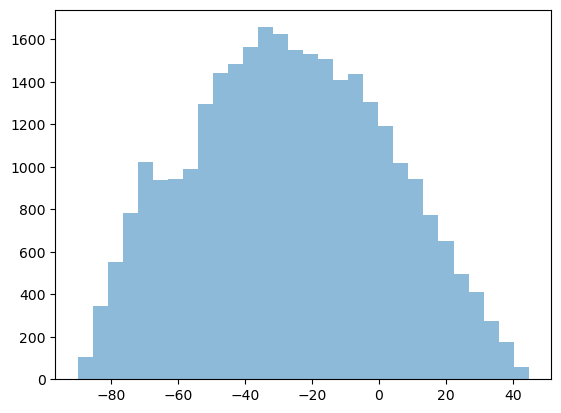

In [ ]:
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u

events_a8 = ascii.read('../data/Auger/events_a8_lb.dat')
eve = SkyCoord(events_a8['RA'], events_a8['dec'], frame='icrs', unit='degree')
mask_eve = np.where(abs(eve.galactic.b) > 5. * u.degree)[0]
events_a8 = events_a8[mask_eve]
#mask_eve = np.where(events_a8['dec']< 0.)[0]
#events_a8 = events_a8[mask_eve]

cr_ra = events_a8['RA']
cr_dec = events_a8['dec']

In [9]:
def generate_RandomCatalogue(N,nmult,dec_max,seed=None, milkyway_mask=True, deflection=None, deflection_file='../data/JF12_GMFdeflection_Z1_E10EeV.csv'):
    import numpy as np
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    
    if seed!=None: np.random.seed(seed)

    ra_min = 0.
    ra_max = 360
    dec_min = -90.
    dec_max = dec_max

    rand_ra = np.random.uniform(ra_min, ra_max, N*nmult*100)
    rand_sindec = np.random.uniform(np.sin(dec_min*np.pi/180.), np.sin(dec_max*np.pi/180.), \
                                    N*nmult*100)
    rand_dec = np.arcsin(rand_sindec)*180./np.pi

    #Eliminates points within 5° in galactic latitude
    if milkyway_mask==True:
        ran = SkyCoord(rand_ra,rand_dec,frame='icrs',unit='degree')
        mask_ran = np.where([abs(ran.galactic.b)>5.*(u.degree)])[1]
        rand_ra = rand_ra[mask_ran]
        rand_dec = rand_dec[mask_ran]

    # If deflection region is specified, select accordingly
    if deflection == 'high' or deflection == 'low':
        randoms = np.column_stack((rand_ra, rand_dec))
        deflection_mask = apply_deflection_mask(deflection_file, randoms[:, 0], randoms[:, 1], deflection)
        randoms = randoms[deflection_mask]
        rand_ra = randoms[:, 0]
        rand_dec = randoms[:, 1]

    rand_ra_cut = rand_ra[:N*nmult]
    rand_dec_cut = rand_dec[:N*nmult]

    # Check if the size of the random catalogue matches the expected size
    if rand_ra_cut.size != N*nmult:
        raise ValueError(f"Random catalogue size mismatch: expected {N*nmult}, got {rand_ra_cut.size}")

    return rand_ra_cut, rand_dec_cut 

rand_ra, rand_dec = generate_RandomCatalogue(N=len(cr_ra), nmult=10, dec_max=45)

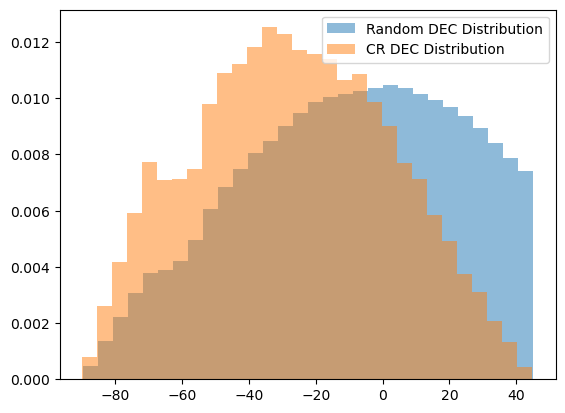

In [14]:
plt.hist(rand_dec, bins=30, alpha=0.5, label='Random DEC Distribution', density=True)
plt.hist(cr_dec, bins=30, alpha=0.5, label='CR DEC Distribution', density=True)
plt.legend()
plt.show()

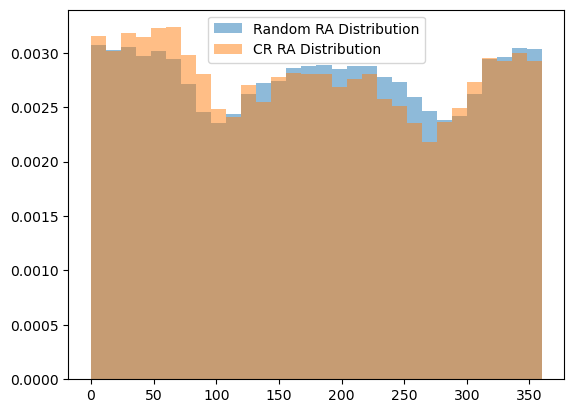

In [15]:
plt.hist(rand_ra, bins=30, alpha=0.5, label='Random RA Distribution', density=True)
plt.hist(cr_ra, bins=30, alpha=0.5, label='CR RA Distribution', density=True)
plt.legend()
plt.show()